In [21]:
import random
def balance(train_list, label_list):
    # 去重
    all = list(set(label_list))
    times = [label_list.count(i) for i in all]
    new_train=train_list
    new_label=label_list
    for i in all:
        tmp_train = []
        for t in range(len(label_list)):
            if label_list[t]==i:
                tmp_train.append(train_list[t])
        for j in range(max(times)-label_list.count(i)):
            new_train.append(tmp_train[random.randint(0,len(tmp_train)-1)]) 
            new_label.append(i)
    return new_train, new_label
balance([1,2,3,4,5,6,7,8,9,10],[1,1,1,1,1,1,1,1,1,2])

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10],
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [25]:
import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

import torchvision.transforms.functional as TF
from torch.autograd import Variable
import torch.nn.functional as F
import io
# from vit_pytorch.efficient import ViT

from linformer import Linformer
from vit_pytorch.vit import ViT
from vit_pytorch.deepvit import DeepViT

import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
import torch

# 获取当前GPU的设备ID
current_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 获取当前GPU已分配的显存
allocated = torch.cuda.memory_allocated(current_device)

# 获取当前GPU已保留的显存
reserved = torch.cuda.memory_reserved(current_device)

print(f"Device: {current_device}")
print(f"Memory Allocated: {allocated} bytes")
print(f"Memory Reserved: {reserved} bytes")

Device: cuda
Memory Allocated: 0 bytes
Memory Reserved: 0 bytes


: 

/opt/conda/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Text(0.5, 1.0, 'labels: 1')

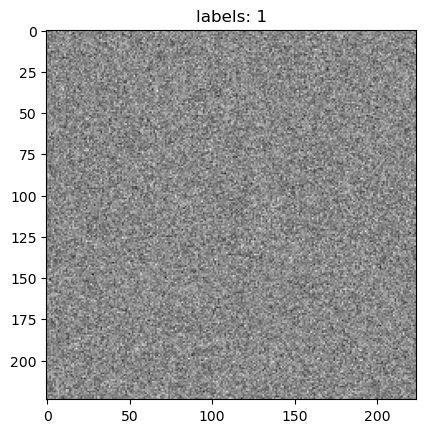

In [4]:
datalist = glob.glob('../*.nii.gz')
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        
    ]
)

class CovidDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_3d = nib.load(self.file_list[idx]).get_fdata()
        # randomly select a 2D slice
        img = img_3d[:, :, np.random.randint(0,img_3d.shape[2]-1)]
        #img = torch.from_numpy(img).unsqueeze(0)
        print('2d-img-shape:',img.shape)
        img_transformed = self.transform(img)
        #print('2d-img-shape=',img_transformed.size(),type(img_transformed))
        #TODO: rewrite the label get method
        label = 1
        
        return img_transformed, label
datasets = CovidDataset(datalist, transform)
plt.imshow(datasets.__getitem__(0)[0].numpy()[0,:,:], cmap='gray', )
plt.title(f"labels: {datasets.__getitem__(0)[1]}")

In [44]:
print(os.listdir('/code/images-with-labels/'))

['PROG0171', 'PROG0013', 'PROG0499', 'PROG0126', 'PROG1632', 'PROG0953', 'PROG0370', 'PROG0681', 'PROG0323', 'PROG0827', 'PROG0180', 'PROG1232', 'PROG1381', 'PROG0128', 'PROG0302', 'PROG0366', 'PROG1344', 'PROG1552', 'PROG1517', 'PROG0093', 'PROG0337', 'PROG0286', 'PROG1407', 'PROG0067', 'PROG0164', 'PROG0184', 'PROG1334', 'PROG0020', 'PROG0232', 'PROG0534', 'PROG1666', 'PROG1288', 'PROG0115', 'PROG0964', 'PROG1026', 'PROG0706', 'PROG1280', 'PROG0066', 'PROG0830', 'PROG1142', 'PROG0852', 'PROG0052', 'PROG0929', 'PROG0176', 'PROG0031', 'PROG0828', 'PROG0412', 'PROG0551', 'PROG0239', 'PROG0151', 'PROG0547', 'PROG1375', 'PROG1053', 'PROG0284', 'PROG0293', 'PROG1713', 'PROG0343']


In [48]:
len(glob.glob('/code/images-with-labels/**/*.nii.gz', recursive=True))

399

# Dataprepocess

In [7]:
import nibabel as nib
import numpy as np
import glob
def nii2npy(file_path, save_path):
    # Load the nii.gz file
    img = nib.load(file_path)
    
    # Get the data as a numpy array
    data = img.get_fdata()
    
    # Save the numpy array
    np.save(save_path, data)
for i in glob.glob('/code/images-with-labels/**/*.nii.gz', recursive=True):
    nii2npy(i, i.replace('.nii.gz', '.npy').replace('/code/images-with-labels/', '/code/images_npy/'))
    print(i)

/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_13_59_26_OD_sn1359.nii.gz
/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_39_48_OS_sn1339.nii.gz
/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_38_50_OS_sn1338.nii.gz
/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_14_1_19_OS_sn1401.nii.gz
/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_37_28_OD_sn1337.nii.gz
/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_14_1_49_OS_sn1401.nii.gz
/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_38_6_OD_sn1338.nii.gz
/code/images-with-labels/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_13_58_11_OD_sn1358.nii.gz
/code/images-with-labels/PROG0013/P001319777_Angiography 6x6 mm_6-5-2020_15_24_27_OD_sn1524.nii.gz
/code/images-with-labels/PROG0013/P001319777_Angiography 6x6 mm_6-5-2020_15_25_51_OS_sn1525.nii.gz
/code/ima

In [6]:
import os
import shutil
def copy_directory_structure(source_folder, destination_folder):
    for root, dirs, files in os.walk(source_folder):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            new_dir_path = dir_path.replace(source_folder, destination_folder)
            os.makedirs(new_dir_path, exist_ok=True)

copy_directory_structure('/code/images-with-labels/', '/code/images_npy/')


In [4]:
# make file-name -> label dictionary
import pandas as pd
ex = pd.read_excel('/code/Sleep-results.xlsx')
label_list = [(ex[ex.iloc[:,0] == i.split('/')[-2]])['sat_avg'].iloc[0] for i in glob.glob('/code/images-with-labels/**/*.nii.gz', recursive=True)]
for i in glob.glob('/code/images-with-labels/**/*.nii.gz', recursive=True):
    st =  i.split('/')[-2]
    label = (ex[ex.iloc[:,0] == st])['sat_avg']
    #label = label['sat_avg'].iloc[0]
    print(label)
label_list  

FileNotFoundError: [Errno 2] No such file or directory: '/code/Sleep-results.xlsx'

In [19]:

for i in glob.glob('/code/images_npy/**/*.npy', recursive=True):
    file = np.load(i)
    np.save(i, file, allow_pickle=False)
    print(i)

    

/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_14_1_49_OS_sn1401.npy
/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_38_6_OD_sn1338.npy
/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_14_1_19_OS_sn1401.npy
/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_37_28_OD_sn1337.npy
/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_13_58_11_OD_sn1358.npy
/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_1-8-2021_13_59_26_OD_sn1359.npy
/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_39_48_OS_sn1339.npy
/code/images_npy/PROG0171/P0048472.0_Angiography 6x6 mm_7-26-2019_13_38_50_OS_sn1338.npy
/code/images_npy/PROG0013/P001319777_Angiography 6x6 mm_3-19-2021_14_55_47_OS_sn1455.npy
/code/images_npy/PROG0013/P001319777_Angiography 6x6 mm_6-5-2020_15_24_53_OD_sn1524.npy
/code/images_npy/PROG0013/P001319777_Angiography 6x6 mm_6-5-2020_15_25_25_OS_sn1525.npy
/code/images_npy/PROG0013/P001

In [18]:
import time

def get_time(f):

    def inner(*arg,**kwarg):
        s_time = time.time()
        res = f(*arg,**kwarg)
        e_time = time.time()
        print('耗时：{}秒'.format(e_time - s_time))
        return res
    return inner
@get_time
def test(idx):
    





耗时：0.008513927459716797秒


In [8]:
# download the data
import gdown
gdown.download('https://drive.google.com/file/d/1YFuc-5nSYjrdnv071hPHi8uaAqs4U0Js/view?usp=drive_link','/code/chen/pretrain', quiet=False, fuzzy=True)

Downloading...
From (original): https://drive.google.com/uc?id=1YFuc-5nSYjrdnv071hPHi8uaAqs4U0Js
From (redirected): https://drive.google.com/uc?id=1YFuc-5nSYjrdnv071hPHi8uaAqs4U0Js&confirm=t&uuid=e81cd149-9fab-4ffe-9dcc-0456b9e30b03
To: /code/chen/pretrain
100%|██████████| 618M/618M [00:16<00:00, 38.3MB/s] 


'/code/chen/pretrain'

加载预训练

In [31]:
efficient_transformer = Linformer(
    dim=1024,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)
model = ViT(
    dim=1024,
    image_size=224,
    patch_size=32,
    num_classes=2,
    depth=12,
    heads=8,
    mlp_dim=1024,
    # transformer=efficient_transformer,
    channels=3,
)
wts = torch.load('/code/chen/pretrain/net.pt', map_location=torch.device('cpu'))
model.load_state_dict(wts, strict=False)
model.mlp_head = nn.Linear(1024,4)

sefl= torch.Size([50, 1024]) torch.Size([1, 1024]) Dropout(p=0.0, inplace=False)
